In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: age_gender.csv          


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# LFW(Labeled Faces in the Wild) 데이터셋 로드
dataset, info = tfds.load('lfw', split='train', with_info=True)

# 이미지 전처리 함수
def preprocess(features):
    # 이미지를 0~1 사이의 float32 타입으로 정규화
    image = tf.cast(features['image'], tf.float32) / 255.
    # 이미지 크기를 (64, 64)로 조절
    image = tf.image.resize(image, (64, 64))
    return image, image # 입력과 출력을 동일하게 설정

# 데이터셋에 전처리 함수 적용 및 배치 구성
train_dataset = dataset.map(preprocess).shuffle(1024).batch(128)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/lfw/incomplete.8QO424_0.1.1/lfw-train.tfrecord*...:   0%|          | 0/132…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.1. Subsequent calls will reuse this data.


In [8]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
LATENT_DIM = 128  # 잠재 공간의 차원
EPOCHS = 30

In [ ]:
# 4. VAE 모델 구축

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # 표준 정규분포에서 랜덤 노이즈(epsilon) 생성
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # z = z_mean + exp(0.5 * z_log_var) * epsilon
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# --- 4.2. 인코더(Encoder) 정의 ---
encoder_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='encoder_input')
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 16384)     │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │  2,097,280 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     16,512 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     16,512 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 128)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,149,696 (8.20 MB)

 Trainable params: 2,149,696 (8.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# --- 4.3. 디코더(Decoder) 정의 ---
# 잠재 공간의 벡터를 입력받아 이미지로 복원(생성)
latent_inputs = layers.Input(shape=(LATENT_DIM,), name='decoder_input')
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# 최종 출력 채널은 3(RGB), 활성화 함수는 sigmoid로 픽셀 값을 0~1 사이로 맞춤
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,169,795 (8.28 MB)

 Trainable params: 2,169,795 (8.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 4.4. VAE 모델 클래스 정의 ---
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # 손실 함수 추적을 위한 Metric 초기화
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # 데이터는 (image, image) 형태로 들어옴
        x, _ = data
        with tf.GradientTape() as tape:
            # 1. 인코더를 통해 잠재 변수 생성
            z_mean, z_log_var, z = self.encoder(x)
            # 2. 디코더를 통해 이미지 복원
            reconstruction = self.decoder(z)

            # 3. 손실 계산
            # 3-1. 복원 손실 (원본 이미지와 복원된 이미지의 차이)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            # 3-2. KL 발산 손실 (잠재 공간 분포를 정규분포에 가깝게 만드는 규제)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # 3-3. 두 손실을 더하여 최종 손실 계산
            total_loss = reconstruction_loss + kl_loss

        # 4. 그래디언트 계산 및 가중치 업데이트
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # 5. 손실 추적
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # 결과 반환
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


 모델 학습 시작...
Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - kl_loss: 3.5667 - loss: 2717.9739 - reconstruction_loss: 2714.4070
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - kl_loss: 8.5692 - loss: 2561.3374 - reconstruction_loss: 2552.7686
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - kl_loss: 9.4050 - loss: 2537.6516 - reconstruction_loss: 2528.2471
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - kl_loss: 9.3738 - loss: 2530.7615 - reconstruction_loss: 2521.3879
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - kl_loss: 9.2373 - loss: 2529.7732 - reconstruction_loss: 2520.5361
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - kl_loss: 9.0013 - loss: 2527.7109 - reconstruction_loss: 2518.7095
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - kl_loss: 9.0677 - loss: 2527.9260 - reconstruction_loss: 2518.8579
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - kl_loss: 9.0679 - loss: 2527.6077 - reconstruction_loss: 2518.5393
Epoch 9/

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

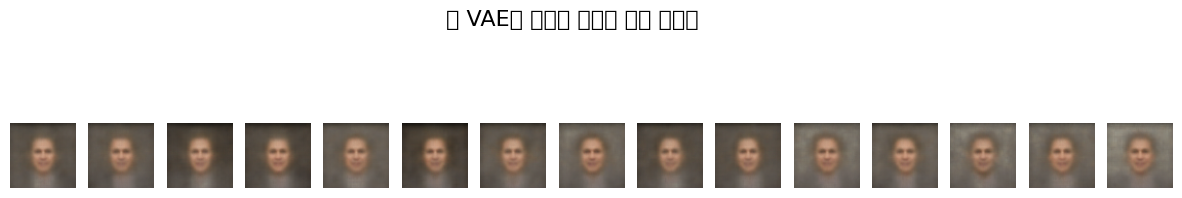

In [ ]:
# 5. 모델 컴파일 및 학습
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

print("\n 모델 학습 시작...")
history = vae.fit(train_dataset, epochs=EPOCHS)
print(" 모델 학습 완료")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


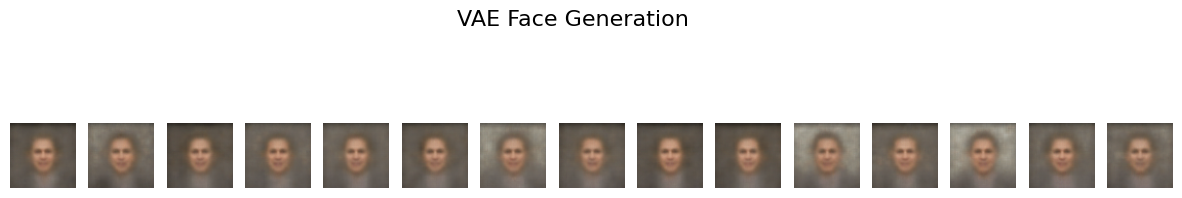

In [16]:
# 6. 새로운 얼굴 이미지 생성 및 시각화
def plot_generated_images(decoder, n_images=15):
    # 표준 정규분포에서 랜덤 잠재 벡터 샘플링
    random_latent_vectors = tf.random.normal(shape=(n_images, LATENT_DIM))
    # 디코더를 사용하여 이미지 생성
    generated_images = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(15, 3))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.suptitle("VAE Face Generation", fontsize=16)
    plt.show()

# 함수 호출하여 결과 확인
plot_generated_images(vae.decoder)